In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#required packages.
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import datetime
import itertools
import argparse
import collections

Prior to using the Earth Engine Python client library, you need to authenticate (verify your identity) and use the resultant credentials to initialize the Python client. The authentication flows use Cloud Projects to authenticate, and they're used for unpaid (free, noncommercial) use as well as paid use. To authenticate and initialize, run the following codes.

https://developers.google.com/earth-engine/guides/auth


In [ ]:
import ee
# # Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='')

## utils

In [ ]:
#must run these codes
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def ee_array_to_df1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

* TerraClimate: Monthly Climate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE

##  OpenLandMap

### point based

In [ ]:
def get_soil_attributes(r_lon, r_lat, scale, band_depth):
    # get selected soil attributes over test areas
    soil_attributes = {}
    soil_attributes['carbon'] = 'OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02'
    soil_attributes['sand'] = 'OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02'
    soil_attributes['clay'] = 'OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02'
    soil_attributes['pH'] = "OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02"
    soil_attributes['texture'] = "OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02"

    soil_attributes['soil_bulk_density'] = 'OpenLandMap/SOL/SOL_BULKDENS-FINEEARTH_USDA-4A1H_M/v02'
    soil_attributes['soil_water_content'] = "OpenLandMap/SOL/SOL_WATERCONTENT-33KPA_USDA-4B1C_M/v01"
    soil_attributes['soil_Hapludalfs'] = "OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX-HAPLUDALFS_P/v01"
    soil_attributes['soil_taxonomy'] = "OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX_C/v01"

    soil_attribute_values = {}
    for key in soil_attributes.keys():
        if key not in {'soil_Hapludalfs', 'soil_taxonomy'}:
          soil = ee.Image(soil_attributes[key]).select(band_depth);
          # Define the location of interest
          r_poi = ee.Geometry.Point(r_lon, r_lat)
          soil_carbon = soil.sample(r_poi, scale).first().getInfo()
          soil_attribute_values[key] = soil_carbon['properties'][band_depth]
        else:
          soil = ee.Image(soil_attributes[key]);
          # Define the location of interest
          r_poi = ee.Geometry.Point(r_lon, r_lat)
          soil_carbon = soil.sample(r_poi, scale).first().getInfo()
          soil_attribute_values[key] = list(soil_carbon['properties'].values())[0]

    return soil_attribute_values

In [ ]:
#test case
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 100
band_depth = 'b10'

soil_attribute_values = get_soil_attributes(r_lon, r_lat, scale, band_depth)
soil_attribute_values

{'carbon': 1,
 'sand': 67,
 'clay': 24,
 'pH': 78,
 'texture': 6,
 'soil_bulk_density': 144,
 'soil_water_content': 11,
 'soil_Hapludalfs': 4,
 'soil_taxonomy': 145}

### Image download

In [ ]:
def get_soil_attributes(image_source, aoi, target_band):
    # Earth Engine Snippet
    band = (ee.Image(image_source)
              .select(target_band))

    #using the median value of multi bands
    band = band.reproject(crs = ee.Projection('EPSG:4326'), scale=10)
    bands2d = band.select(target_band).sampleRectangle(aoi)

    #convert band to array
    band_arr = bands2d.get(target_band)
    arr2d = np.array(bands2d.getInfo()['properties'][target_band])

    return arr2d

In [ ]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])

target_band = 'b10'
#select downloading bands and resources
image_source = 'OpenLandMap/SOL/SOL_BULKDENS-FINEEARTH_USDA-4A1H_M/v02'
arr2d = get_soil_attributes(image_source, aoi, target_band)

In [ ]:
np.save(path + 'gee2Ddata/soil_bulk_densityV.npy', arr2d)

    soil_attributes = {}
    soil_attributes['carbon'] = 'OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02'
    soil_attributes['sand'] = 'OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02'
    soil_attributes['clay'] = 'OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02'
    soil_attributes['pH'] = "OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02"
    soil_attributes['texture'] = "OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02"

    soil_attributes['soil_bulk_density'] = 'OpenLandMap/SOL/SOL_BULKDENS-FINEEARTH_USDA-4A1H_M/v02'
    soil_attributes['soil_water_content'] = "OpenLandMap/SOL/SOL_WATERCONTENT-33KPA_USDA-4B1C_M/v01"
    soil_attributes['soil_Hapludalfs'] = "OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX-HAPLUDALFS_P/v01"
    soil_attributes['soil_taxonomy'] = "OpenLandMap/SOL/SOL_GRTGROUP_USDA-SOILTAX_C/v01"
    

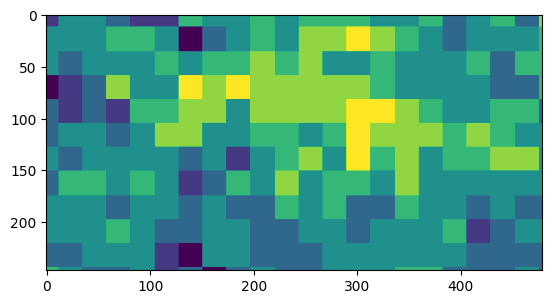

In [ ]:
plt.imshow(arr2d)

## SoilGrids

In [ ]:
def get_soil_grids(r_lon, r_lat, scale, band_depth):
    soil_attribute_values = {}
    soil_attributes = {}
    soil_attributes['bdod'] = "projects/soilgrids-isric/bdod_mean"
    soil_attributes['cec'] = "projects/soilgrids-isric/cec_mean"

    soil_attributes['cfvo'] = "projects/soilgrids-isric/cfvo_mean"
    soil_attributes['clay'] = "projects/soilgrids-isric/clay_mean"
    soil_attributes['nitrogen'] = "projects/soilgrids-isric/nitrogen_mean"
    soil_attributes['ocd'] = "projects/soilgrids-isric/ocd_mean"

    soil_attributes['ocs'] = "projects/soilgrids-isric/ocs_mean"
    soil_attributes['phh2o'] = "projects/soilgrids-isric/phh2o_mean"
    soil_attributes['sand'] = "projects/soilgrids-isric/sand_mean"
    soil_attributes['silt'] = "projects/soilgrids-isric/silt_mean"
    soil_attributes['soc'] = "projects/soilgrids-isric/soc_mean"

    for key in soil_attributes.keys():
        #generate band depth index
        if key in {'ocs'}:
          band_depth_index = key+"_0-30cm_mean"
        else:
          band_depth_index = key+band_depth

        soil = ee.Image(soil_attributes[key]).select(band_depth_index);
        # Define the location of interest
        r_poi = ee.Geometry.Point(r_lon, r_lat)
        soil_carbon = soil.sample(r_poi, scale).first().getInfo()
        soil_attribute_values[key] = soil_carbon['properties'][band_depth_index]

    return soil_attribute_values

In [ ]:
#test case
scale = 100
r_lon, r_lat = 2.4377389809555, 30.95203025969217
band_depth = '_5-15cm_mean'
get_soil_grids(r_lon, r_lat, scale, band_depth)

{'bdod': 142,
 'cec': 153,
 'cfvo': 249,
 'clay': 212,
 'nitrogen': 592,
 'ocd': 96,
 'ocs': 18,
 'phh2o': 85,
 'sand': 505,
 'silt': 283,
 'soc': 47}

In [ ]:
pd.DataFrame.from_dict([soil_attribute_values])

,bdod,cec,cfvo,clay,nitrogen,ocd,ocs,phh2o,sand,silt,soc
0,128,171,115,247,531,288,41,81,618,135,197
